In [121]:
import numpy as np
from enum import Enum
from queue import PriorityQueue
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = 12, 12

In [122]:
def create_grid(data, safety_distance, drone_altitude):
    """From colliders.csv data create a grid with obstacles (1) and free space (0)

    Args:
        data (ndarray): colliders csv as list
        safety_distance (int): max distance between drone and obstacle
        drone_altitude (int): static drone altitude

    Returns:
        matrix: NxN grid with 1 as obstacles and 0 as free space
    """
    
    north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))
    north_size = int(np.ceil((north_max - north_min)))

    east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))
    east_size = int(np.ceil((east_max - east_min)))

    grid = np.zeros((north_size, east_size))

    for obstacle_idx in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[obstacle_idx, :]

        if alt + d_alt + safety_distance > drone_altitude:
            north_start = int(north - d_north - safety_distance - north_min)
            north_end = int(north + d_north + safety_distance - north_min)

            east_start = int(east - d_east - safety_distance - east_min)
            east_end = int(east + d_east + safety_distance - east_min)

            grid[north_start:north_end, east_start:east_end] = 1

    return grid

In [123]:
def find_path(grid, start, goal):
    """Find shortest path from start to end with A* algorithm

    Args:
        grid (matrix): space grid with obstacles
        start (tuple): start position
        goal (tuple): goal position
        
    Returns:
        list of tuples: list of all visited points
    """
    
    class Action(Enum):
        # (i, j, cost)
        LEFT = (0, -1, 1)
        RIGHT = (0, 1, 1)
        UP = (-1, 0, 1)
        DOWN = (1, 0, 1)
        UR_DIAG = (-1, 1, 1.41)
        UL_DIAG = (-1, -1, 1.41)
        DR_DIAG = (1, 1, 1.41)
        DL_DIAG = (1, -1, 1.41)

        def __str__(self):
            if self == self.LEFT:
                return '<'
            elif self == self.RIGHT:
                return '>'
            elif self == self.UP:
                return '^'
            elif self == self.DOWN:
                return 'v'
            elif self == self.UR_DIAG:
                return '/^'
            elif self == self.UL_DIAG:
                return '\\^'
            elif self == self.DR_DIAG:
                return '\\v'
            elif self == self.DL_DIAG:
                return '/v'

        @property
        def cost(self):
            return self.value[2]
        
        @property
        def delta(self):
            return (self.value[0], self.value[1])
    
    def valid_moves(current):
        valid = []
        for act in Action:
            delta = act.value
            next_pos = (current[0] + delta[0], current[1] + delta[1])

            is_inside_grid = (next_pos[0] >= 0 and next_pos[0] < len(grid)) and (next_pos[1] >= 0 and next_pos[1] < len(grid[0])) 
            
            if is_inside_grid and grid[next_pos] != 1:
                valid.append(act)
            
        return valid

    def dist(pos, goal):
        return sqrt(abs(goal[0]-pos[0])**2 + abs(goal[1]-pos[1])**2)
    
    q = PriorityQueue()     # points to value (dist+price, dist, price, coord)
    q.put((dist(start, goal), 0, start))

    visited = set()         # visited points
    visited.add(start)

    branch = {}             # history of path

    count = 0               # count computations

    while True:
        curr = q.get()
        cost = curr[1]
        pos = curr[2]

        if pos == goal:
            break

        for action in valid_moves(pos):
            count += 1
            
            new_pos = (pos[0] + action.delta[0], pos[1] + action.delta[1])
            new_dist = dist(new_pos, goal)
            new_cost = cost + action.cost

            if new_pos not in visited:
                visited.add(new_pos)
                q.put((new_dist+new_cost, new_cost, new_pos))
                branch[new_pos] = (pos, action, new_cost)
        
            elif new_pos in branch and branch[new_pos][2] > new_cost:
                branch[new_pos] = (pos, action, new_cost)



    path = []
    curr = goal

    while branch[curr][0] != start:
        # append each new node to the path
        path.append(branch[curr][0])
        curr = branch[curr][0]
        
    return path

In [124]:
def prune_path(path):
    def collinearity(p1, p2, p3, epsilon=1):
        # p1, p2, p3: 3D floats
        if len(p1) == 2:
            p1 = (p1[0], p1[1], 1)
            p2 = (p2[0], p2[1], 1)
            p3 = (p3[0], p3[1], 1)
        
        mat = np.vstack((p1, p2, p3))
        det = np.linalg.det(mat)

        if abs(det) < epsilon:
            return True
        
        return False
    
    pruned_path = [p for p in path]

    i = 0
    while i < len(pruned_path)-2:
        are_collinear = collinearity(pruned_path[i], pruned_path[i+1], pruned_path[i+2])
        if are_collinear:
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1  


    return pruned_path


In [125]:
def create_path(colliders_filename, start, goal, safety_distance=3, altitude=5):

    # from file get grid
    data = np.loadtxt(colliders_filename, delimiter=',', dtype='float64', skiprows=2)
    grid = create_grid(data, safety_distance, altitude)

    # from grid get path
    path = find_path(grid, start, goal)

    # remove useless points
    pruned_path = prune_path(path)
    
    return pruned_path, grid

[(690, 199), (689, 198), (689, 197), (688, 196), (688, 195), (687, 194), (687, 193), (686, 191), (686, 190), (684, 187), (683, 184), (681, 181), (681, 179), (680, 177), (678, 174), (677, 170), (676, 168), (675, 167), (675, 166), (674, 165), (674, 164), (673, 163), (673, 162), (672, 161), (672, 159), (671, 158), (670, 156), (669, 154), (667, 151), (652, 136), (607, 136), (597, 146), (577, 146), (575, 148), (574, 148), (573, 147), (571, 147), (569, 146), (517, 146), (507, 156), (447, 156), (437, 166), (427, 166), (417, 176), (337, 176), (330, 183), (157, 183), (156, 175), (156, 172), (146, 162), (146, 140), (106, 100), (26, 100)]


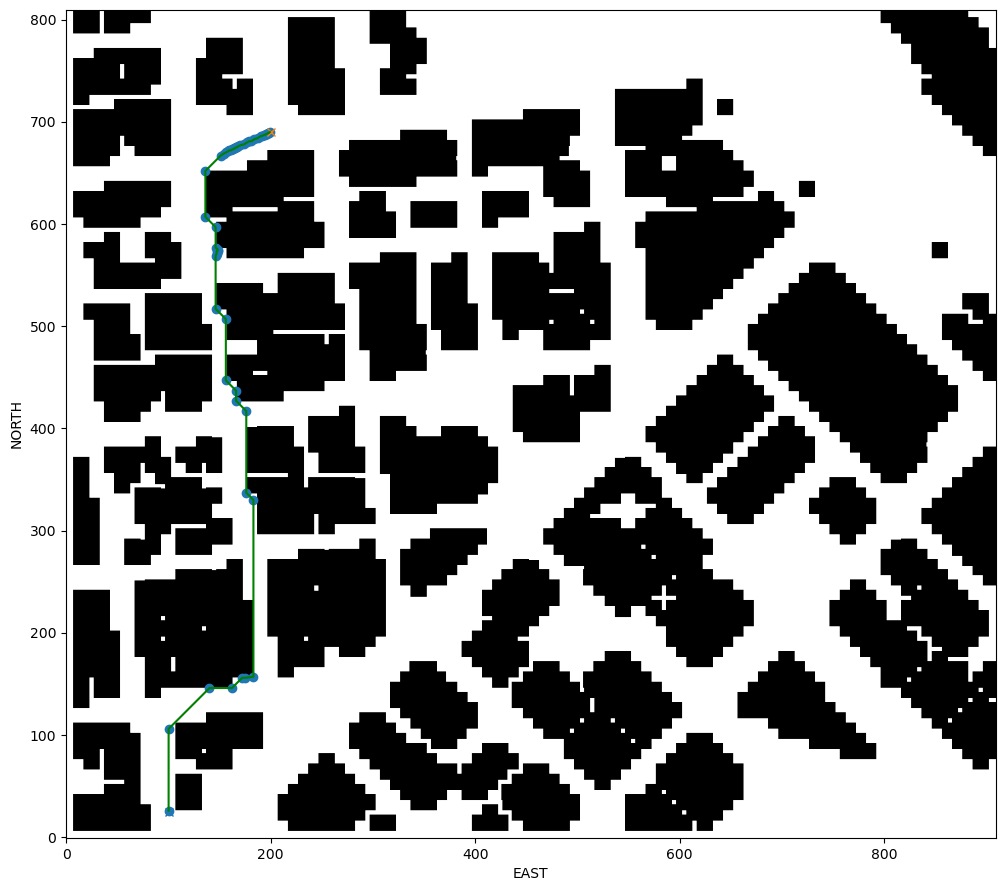

In [126]:
start = (25, 100)
goal = (690, 200)

path, grid = create_path('colliders.csv', start, goal)
print(path)

plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start[1], start[0], 'x')
plt.plot(goal[1], goal[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()